<a href="https://colab.research.google.com/github/Pehlevan-Group/sgd_structured_features/blob/main/SGD_LC_Theory_NTK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q git+https://www.github.com/google/neural-tangents

import numpy as np
import math
import matplotlib.pyplot as plt
import jax.numpy as jnp

from jax import random
from jax.experimental import optimizers
from jax.api import jit, grad, vmap
import functools
import neural_tangents as nt
from neural_tangents import stax
import sys

from jax.config import config
config.update("jax_debug_nans", True)


import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from google.colab import drive
import scipy as sp
import scipy.optimize
import pandas as pd

from jax.experimental.ode import odeint

#drive.mount('/content/gdrive', force_remount=True)
#root_dir = "/content/gdrive/My Drive/"

In [ ]:
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"

Mounted at /content/gdrive


In [ ]:
num_tot = 50000
num_classes = 10
name = 'mnist'
ds = tfds.load(name, split=tfds.Split.TRAIN).shuffle(1024).batch(num_tot)

plt.rcParams.update({'font.size': 12})

for i,ex in enumerate(ds):
  Xtf = ex['image']
  image = Xtf.numpy() / 255.0
  X = np.reshape(image, (image.shape[0], image.shape[1]*image.shape[2]*image.shape[3]))
  image = jnp.array( image.transpose((0,3,1,2)) )
  y = ex['label'].numpy()
  y_mat = np.eye(10)[y]
  break

ds = tfds.load(name, split=tfds.Split.TEST).shuffle(1024).batch(num_tot)

for i,ex in enumerate(ds):
  Xtf_te = ex['image']
  image_test = Xtf_te.numpy() / 255.0
  print(image_test.shape)
  Xte = np.reshape(image_test, (image_test.shape[0], image_test.shape[1]*image_test.shape[2]*image_test.shape[3]))
  image_test = image_test.transpose((0,3,1,2))
  yte = ex['label'].numpy()
  y_mat_te = np.eye(10)[yte]
  break

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
(10000, 28, 28, 1)


In [ ]:


def fully_connected(width, depth):
  layers = []
  for l in range(depth):
    layers += [stax.Dense(width), stax.Relu()]
  layers += [stax.Dense(10)]
  return stax.serial(*layers)


def convnet(k, depth, pool = True):
  layers = []
  for l in range(depth):
    #layers += [stax.Conv(k, (3, 3), (1,1)), stax.Relu()]
    layers += [stax.Conv(k, (3, 3), padding='SAME'), stax.Relu()]
  if pool == True:
    layers += [stax.GlobalAvgPool(), stax.Dense(10)]
  else:
    layers += [stax.Flatten(), stax.Dense(10)]
  return stax.serial(*layers)


In [ ]:
width = 5000
depth_vals = [1,2,5]

all_eigs = []
all_v = []
all_K = []

P_sub = 10000

for i, d in enumerate(depth_vals):
  init_fn, apply_fn, kernel_fn = fully_connected(width, d)
  
  K = kernel_fn(X[0:P_sub,:], None, 'ntk')
  all_K += [K]

  eigs, vec = jnp.linalg.eigh(1/K.shape[0] * K)

  v = 1/K.shape[0] * jnp.sum( (vec.T @ y_mat[0:P_sub,:])**2 , axis = 1)
  indsort = jnp.argsort(eigs)[::-1]


  all_eigs += [ eigs[indsort] ]
  all_v += [ v[indsort] ]


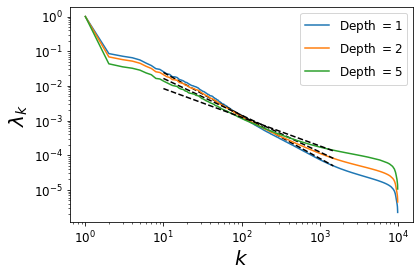

[1.2379162420017915, 1.0587285292070958, 0.8257389094075582]


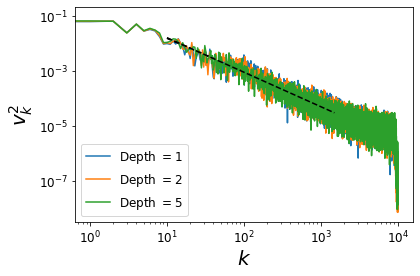

[1.2112661728196015, 1.2256794031867506, 1.2549758775964714]


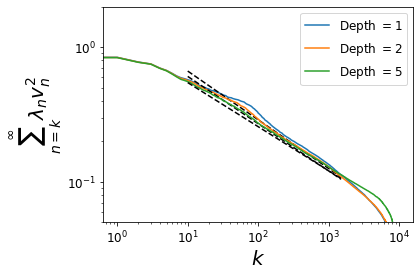

[0.36231614946859847, 0.3514440397749614, 0.3278644995127625]


In [ ]:
def extract_power_law(spec, start=0, end=None, xarr = []):
  if end == None:
    end = len(spec)
  inds= np.linspace(start, end, end - start) 
  if len(xarr) > 0:
    inds = xarr[start:end]
  beta = - np.cov(np.log(inds), np.log(spec[start:end]))[0,1] / np.var(np.log(inds))
  return beta

all_b = []
start = 10
end = 1500
for i,d in enumerate(depth_vals):
  b_i = extract_power_law( all_eigs[i], start,end)
  eig_i = all_eigs[i]/all_eigs[i][0]
  plt.loglog( np.linspace(1,len(all_eigs[i]), len(all_eigs[i])), eig_i , label = r'Depth $ = %d$' % d)
  pred =  np.linspace(start,end, end-start)**(-b_i)
  pred = pred * np.mean(eig_i[start:end]) /  np.mean(pred)
  plt.loglog( np.linspace(start, end, end-start), pred  , '--', color = 'black')
  all_b += [b_i]
plt.xlabel(r'$k$',fontsize = 20)
plt.ylabel(r'$\lambda_k$',fontsize =20)
#plt.title('Kernel Eigenvalues', fontsize = 20)
plt.legend()
plt.tight_layout()
plt.savefig(root_dir + 'mnist_spectra_scaling_exponents_depth_no_fit.pdf')
plt.show()
print(all_b)

all_a = []
for i, d in enumerate(depth_vals): 
  plt.loglog(all_v[i], label = r'Depth $ = %d$' % d)
  a_i = extract_power_law( all_v[i], start,end)
  all_a += [a_i]
  pred = np.linspace(start,end, end-start)**(-a_i)
  pred = pred/np.mean(pred) * np.mean(all_v[i][start:end])
  plt.loglog( np.linspace(start,end, end-start), pred, '--', color = 'black' )

plt.xlabel(r'$k$',fontsize = 20)
plt.ylabel(r'$v_k^2$',fontsize =20)
#plt.title('Task Power Spectrum', fontsize= 20)
plt.legend()
plt.tight_layout()
plt.savefig(root_dir + 'mnist_task_scaling_exponents_depth_no_fit.pdf')
plt.show()

print(all_a)

all_a2 = []
for i, d in enumerate(depth_vals): 
  cum_v = np.cumsum(all_v[i]) / np.sum(all_v[i])
  acumv = ( 1-cum_v ) * len(cum_v) / (10+len(cum_v) - np.linspace(1,len(cum_v), len(cum_v)))
  plt.loglog(acumv, label = r'Depth $ = %d$' % d)
  a_i = extract_power_law( acumv, start,end)
  all_a2 += [a_i]
  pred = np.linspace(start,end, end-start)**(-a_i)
  pred = pred/np.mean(pred) * np.mean(1-cum_v[start:end])
  plt.loglog( np.linspace(start,end, end-start), pred, '--', color = 'black' )

plt.xlabel(r'$k$',fontsize = 20)
plt.ylabel(r'$\sum_{n=k}^\infty \lambda_n v_n^2 $',fontsize =20)
plt.ylim([5e-2,2])
#plt.title('Task Power Spectrum', fontsize= 20)
plt.legend()
plt.tight_layout()
plt.savefig(root_dir + 'mnist_task_scaling_exponents_depth_tailsum_no_fit.pdf')
plt.show()
print(all_a2)

In [ ]:
def theory(s, teach, eta, T, m = 1, noise = 0):
    A = jnp.eye(len(s)) - 2*eta*jnp.diag(s) + 1.0*(m+1)/m *eta**2 * jnp.diag(s**2) + 1.0/m * eta**2 * jnp.outer(s, s)
    Inv_mat = jnp.linalg.inv(jnp.eye(A.shape[0]) - A)
    x = s.copy()
    theory_loss = []
    for t in range(T):
        losst = np.dot(x, teach) + 1.0/m * eta**2 * noise**2 * jnp.dot(s, Inv_mat @ (s-x))
        theory_loss += [losst]
        x = A @ x
    return jnp.array( theory_loss )

eta = 4.178560e+00
eta = 5.691562e+00
eta = 2.416117e+01


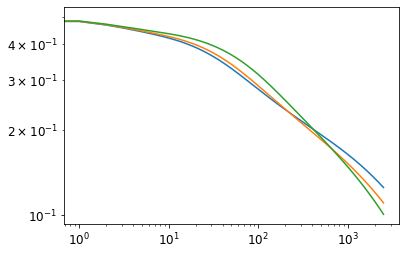

In [ ]:
T = 2500
all_theory_curve = []
for i, eigi in enumerate(all_eigs):
  s = eigi
  eta = 0.2/np.amax(eigi)
  print("eta = %e" % eta)
  v = all_v[i]
  all_theory_curve += [ theory(s, v/s, eta, T, m = 10) ]


for i, ti in enumerate(all_theory_curve):
  plt.loglog(2*all_theory_curve[i])
plt.show()


In [ ]:
import sys

width = 1000
depth_vals = [1, 2, 5]

batch_size = 10
all_train = []
all_test = []


for i, d in enumerate(depth_vals):
  print("Depth: %d" % d)
  init_fn, apply_fn, kernel_fn = fully_connected(width, d)
  _, params = init_fn(random.PRNGKey(1), (-1,784))

  loss = jit( lambda params, Xtr, ytr: 10*jnp.mean(  ( apply_fn(params, Xtr) - ytr)**2  ) )
  test_loss = jit( lambda params: 10*jnp.mean( ( apply_fn(params, Xte[0:1000,:]) - y_mat_te[0:1000,:])**2  ) )
  grad_fn  = jit(grad(loss, 0))

  # idea: linearize network at initialization and look at feature eigendecomposition
  # compare linearized neural network to full training.

  eta = 0.05/np.amax(all_eigs[i])

  opt_init, opt_update, get_params = optimizers.sgd(eta)
  opt_state = opt_init(params)

  train = []
  test = []
  for t in range(5000):
    start = (batch_size * t) % 50000
    train_loss = loss(get_params(opt_state),  X[start:start+batch_size,:], y_mat[start:start+batch_size,:] )
    opt_state = opt_update(t, grad_fn(get_params(opt_state), X[start:start+batch_size,:], y_mat[start:start+batch_size,:]) , opt_state)
    if t >= 0:
      train += [train_loss]
      test  += [test_loss(get_params(opt_state))]
    else:
      train += [ t/(t+1) * train[-1] + 1/(t+1) * train_loss ]
      test += [t/(t+1) * test[-1] + 1/(1+t) * test_loss(get_params(opt_state))]

    #sys.stdout(loss(get_params(opt_state)))
    if t % 10 ==0:
      sys.stdout.write('\r loss: %.4f | train_step: %d' % (test[-1], t))
  print(" ")

  all_train += [train]
  all_test += [test]





Depth: 1
 loss: 0.3051 | train_step: 4990 
 
Linearized Net $D = 1$
 loss: 0.3117 | train_step: 4990 
Depth: 2
 loss: 0.2491 | train_step: 4990 
 
Linearized Net $D = 2$
 loss: 0.2745 | train_step: 4990 
Depth: 5
 loss: 0.1248 | train_step: 4990 
 
Linearized Net $D = 5$
 loss: 0.2839 | train_step: 4990 


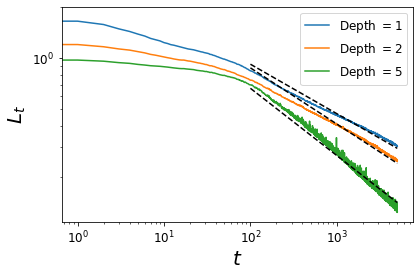

In [ ]:
for i, ti in enumerate(all_test):
  plt.loglog(ti, label = r'Depth $ = %d$' % depth_vals[i])
  arr = jnp.linspace(100,5000, 5000)**(-all_a2[i]/all_b[i])
  arr = arr / np.mean(arr) * np.mean(ti[100:5000])
  plt.loglog(jnp.linspace(100,5000,5000), arr, '--', color = 'black')

plt.xlabel(r'$t$',fontsize = 20)
plt.ylabel(r'$L_t$', fontsize =20)
plt.legend()
plt.tight_layout()
plt.savefig(root_dir + 'mlp_depth_scalings.pdf')
plt.show() 

